<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/23_2_%D0%A1%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B0%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Анализ временных рядов](https://colab.research.google.com/drive/1q9nM-aWF6wZ2XuBxjQEAgjKxrL45axit)
2. Сравнение архитектур нейронных сетей для обработки временных рядов
3. [Домашняя работа](https://colab.research.google.com/drive/181g4qP5fB9PsqGCkcKAR37btxpRMU1Zt)

Мы продолжаем изучать временные ряды. Теперь нам необходимо изучить генератор временных рядов и применить его для подготовки данных и обучить на них различные архитектуры нейронных сетей. Сделать соответствующие выводы.

## Подготовка данных

### Импорт библиотек и загрузка данных

In [1]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Построение моделей нейронных сетей
from keras.models import Sequential, Model

# Слои
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization
from keras.layers import Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D
from keras.layers import MaxPooling1D, RepeatVector

# Оптимизаторы
from keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировка
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Отрисовка графиков
import matplotlib.pyplot as plt
%matplotlib inline

# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

# Отключение лишних предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
# импортируем файл с данными о котировках акций Apple
!wget https://storage.yandexcloud.net/academy.ai/AAPL.csv

# Загрузим только необходимые колонки usecols, укажем, что колонку Date необходимо преобразовать в формат DateTime (parse_dates) и сделать индексом index_col
price = pd.read_csv("./AAPL.csv", index_col='Date', usecols = ['Adj Close', 'Volume', 'Date'], parse_dates=['Date'])
price.head()

--2024-12-29 07:57:48--  https://storage.yandexcloud.net/academy.ai/AAPL.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186539 (182K) [text/csv]
Saving to: ‘AAPL.csv’

AAPL.csv            100%[===================>] 182.17K   242KB/s    in 0.8s    

2024-12-29 07:57:50 (242 KB/s) - ‘AAPL.csv’ saved [186539/186539]



,Adj Close,Volume
Date,,
2014-01-02,17.296652,234684800
2014-01-03,16.916719,392467600
2014-01-06,17.008968,412610800
2014-01-07,16.887323,317209200
2014-01-08,16.994270,258529600


### Визуализация временного ряда

Построим на одном полотне 2 графика с приведенной ценной закрытия (с учётом корпоративных действий) и объемом торгов по акции.

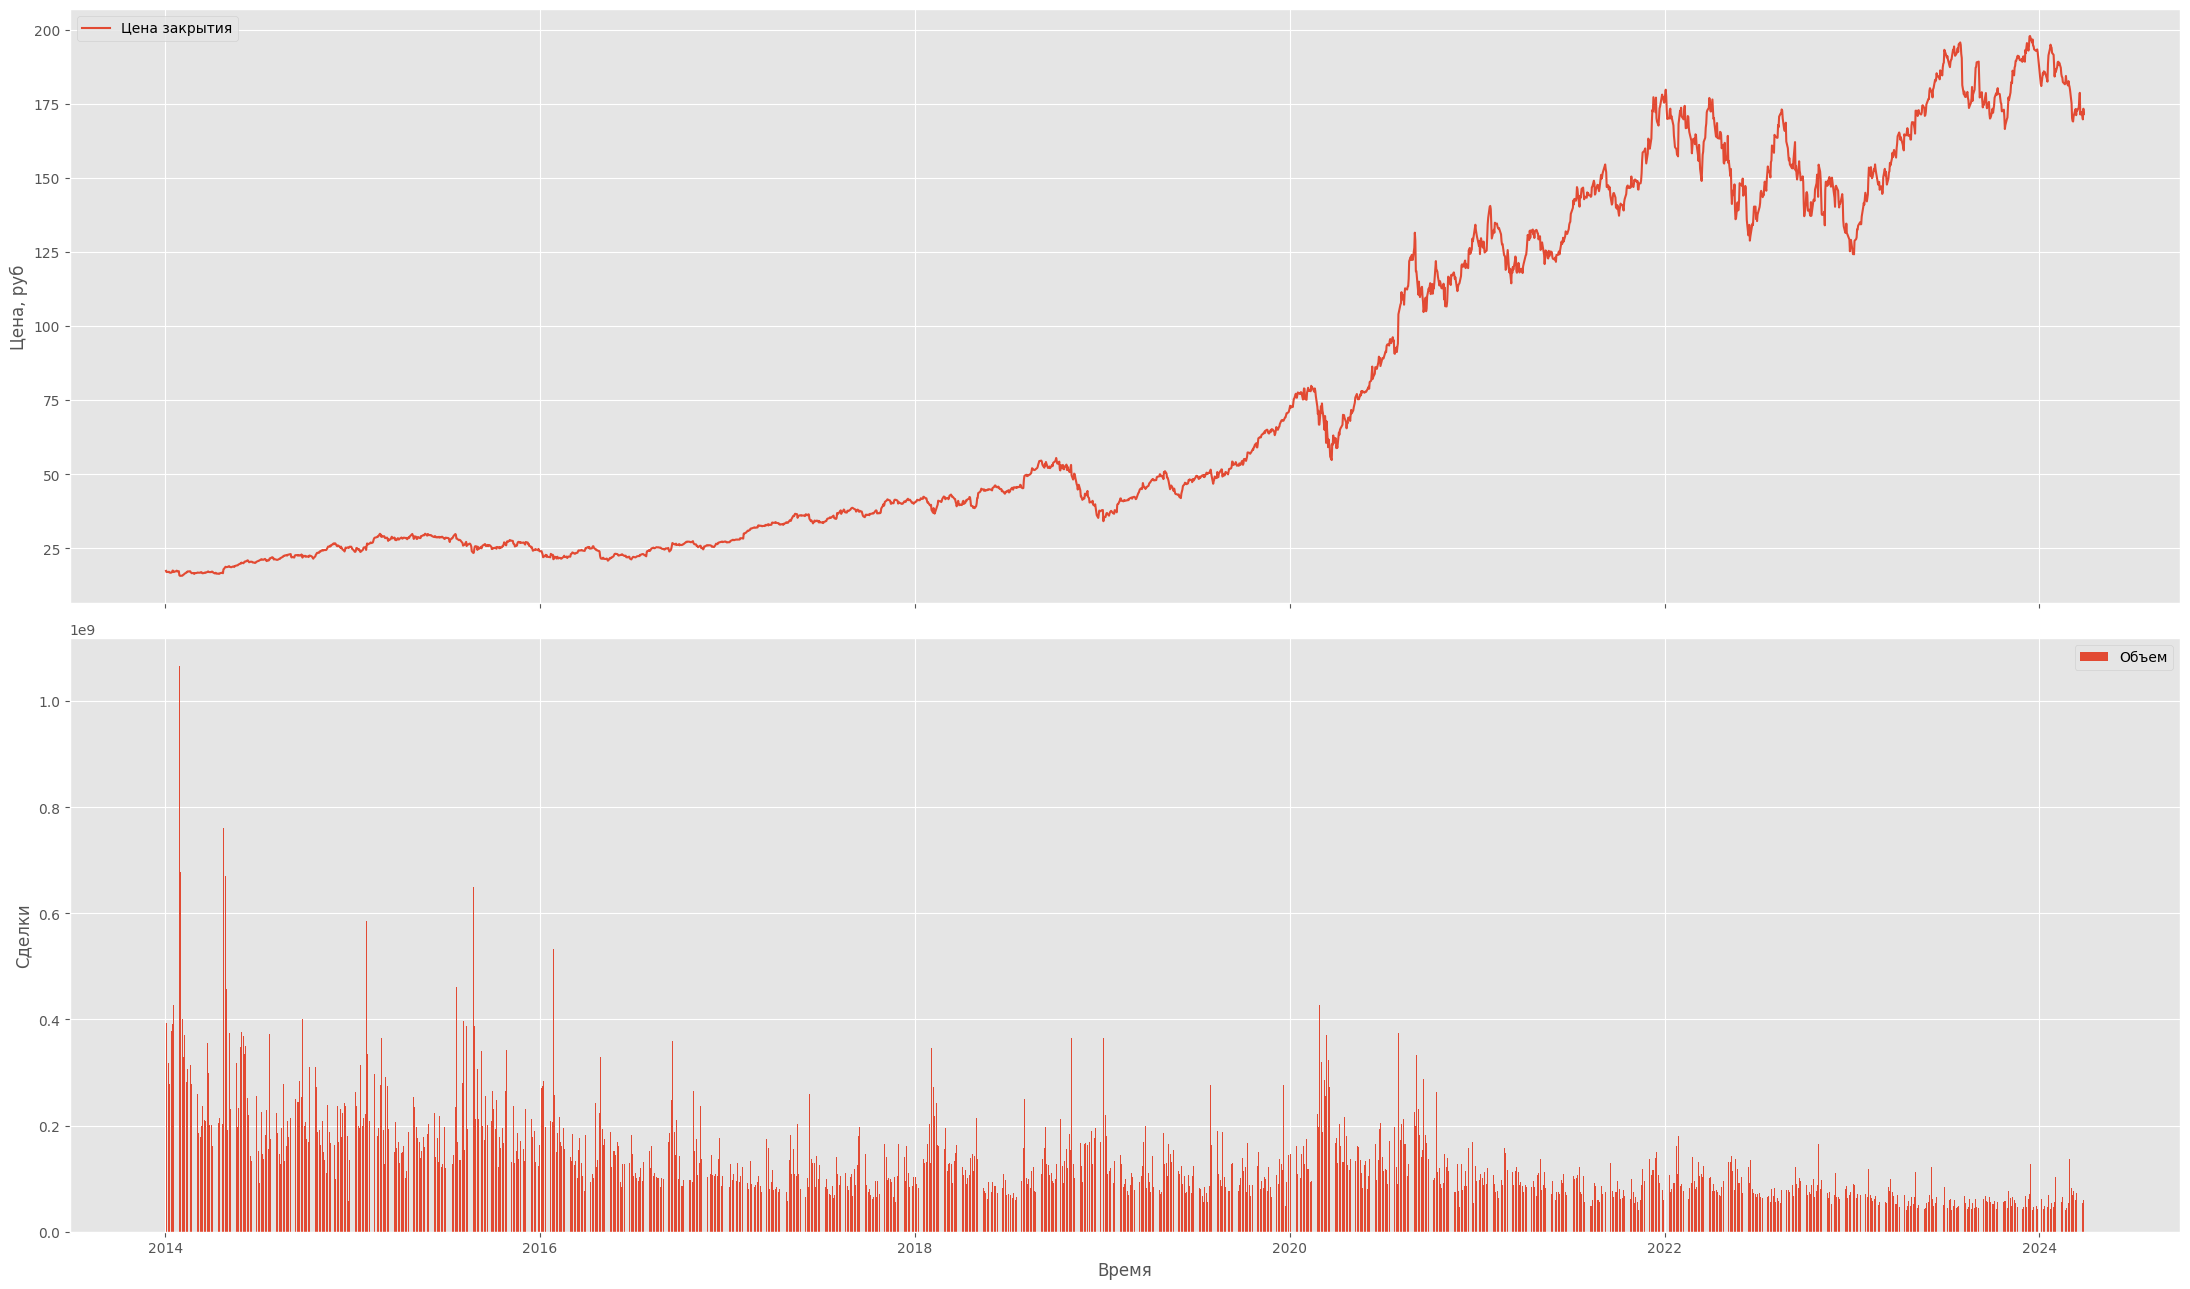

In [3]:
# Задание полотна для графиков - два подграфика один под другим с общей осью x
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 13), sharex=True)


# Отрисовка одного канала данных
# От начальной точки start длиной length
ax1.plot(price.index, price['Adj Close'], label='Цена закрытия')

ax1.set_ylabel('Цена, руб')
ax1.legend()

# Канал volume (объем)
ax2.bar(x=price.index,
        height=price['Volume'],
        label='Объем')
ax2.set_ylabel('Сделки')
ax2.legend()

plt.xlabel('Время')
# Регулировка пределов оси x
# plt.xlim(0, length)
# Указание расположить подграфики плотнее друг к другу
plt.tight_layout()
# Фиксация графика
plt.show()

Далее нам необходимо подготовить выборки.

### Генератор временных рядов

Чтобы вручную не делить выборки для работы с временными рядами Keras предоставляет готовый инструмент **TimeseriesGenerator**.


Параметры генератора TimeseriesGenerator:
* x_train – временной ряд, из которого собираются данные.
* y_train – целевые значения.
* length – длина выходных последовательностей, окно, которым генератор пройдется по данным.
* sampling_rate – размер шага при выборке данных в x_train.
* stride – указывает, на сколько элементов между двумя выборками осуществлять сдвиг.
* batch_size – сколько элементов вернет генератор при обращении к нему.


Чтобы понять как работает генератор, выполним простой пример:

In [8]:
# Простая последовательность
series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# параметры генератора
n_input = 4
batch_size = 2
generator = TimeseriesGenerator(series, series, length=n_input, batch_size=batch_size)

# Число сгенерированных примеров
print('Число примеров: %d' % len(generator))

# Вывод для каждого примера
for i in range(len(generator)):
	x, y = generator[i]

	print('%s => %s' % (x, y))

Число примеров: 3
[[1 2 3 4]
 [2 3 4 5]] => [5 6]
[[3 4 5 6]
 [4 5 6 7]] => [7 8]
[[5 6 7 8]
 [6 7 8 9]] => [ 9 10]


Как видно из примера генератор в качестве входных данных выдает мини-батчи (в нашем случае с одним примером) с последовательностью из `n_input` значений, а в качестве выходного следующее значение в последовательности.

Чтобы лучше понять как работают генераторы выполните 3-4 примера с разными значениями параметров генератора (изменяйте `n_input` и `batch_size`, перезапуская ячейку, проанализируйте вывод ячейки).

#### Подготовка данных для генератора

**Шаг 1**. Для начала удалим столбец `Volume`, который нам был нужен для красивого графика. Обучение НС мы будем проводить только по приведенной цене закрытия `Adj Close`.

In [9]:
price.drop(columns=['Volume'], inplace=True)

**Шаг 2**. Разобьем последовательность на тестовую и обучающую выборки. Дату, которую мы выбрали  - начало года, но пропустили период, который на фондовом рынке называется "гонка" или "ралли" (рост в предновогодние дни и после резкое падение) и период восстановления после "гонки", пока рынок отыграет свои позиции. Таким образом наша модель будет предсказывать поведение рынка после "гонки", что скорее всего приведет к смещению нашего графика с прогнозными ценами вверх или вниз (в зависимости от того, угадали ли мы, что рынок восстановился или нет).

In [10]:
train_data = price[:'2023-01-10']
test_data = price['2023-01-20':]

Между выборками мы пропустили несколько дней, чтобы уменьшить влияние обучающей выборки на тестовую.

**Шаг 3**. Не забываем про нормировку. Особенно если бы мы обучали одновременно модель на цене закрытия вместе с объемом торгов, так как эти данные разных порядков.

При работе с временными рядами необходимо также нормирование данных перед их отправкой в генератор.

Напомним, что **StandardScaler** приводит данные с параметрами среднее равное 0 и среднеквадратичным отклонением равное 1.

**MinMaxScaler** может иметь два диапазона:  $[−1;1]$  и  $[0;1]$.

Данные можно нормировать как все сразу, так и столбцы по отдельности.

Для каждого нормирования важно подобрать правильную активационную функцию на выходном слое. Для **StandardScaler** используют `linear`, так как он выдает результат во всем числовом диапазоне. **Для MinMaxScaler** с диапазоном  $[−1;1]$, используют как `linear`, так и `tanh`. Для **MinMaxScaler** с диапазоном $[0;1]$  используют `sigmoid` и `relu`.

In [13]:
train_data

,Adj Close
Date,
2014-01-02,17.296652
2014-01-03,16.916719
2014-01-06,17.008968
2014-01-07,16.887323
2014-01-08,16.994270
...,...
2023-01-04,125.497505
2023-01-05,124.166641
2023-01-06,128.735229


In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

**Шаг 4**. Запускаем генератор для обучающей выборки. По 14 точкам примера, будем предсказывать следующую. Т.е. каждый обучающий пример будет содержать 14 входных точек и 1 целевую (или выходную).

In [12]:
# Проверка формы данных
print(f'Тренировочные данные: {scaled_train_data.shape}')
print(f'Тестовые данные: {scaled_test_data.shape}')

Тренировочные данные: (2272, 1)
Тестовые данные: (299, 1)


Мы будем обучать модель на малом числе образцов, так как берем дневные графики биржевых цен.

In [14]:
n_input = 14  # Размерность входных данных
n_features = 1 # Размерность выходных данных
BATCH_SIZE = 1 # Размер пакета

generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма обучающего пакета: {generator[0][0].shape}, y: {generator[0][1].shape}')

Форма обучающего пакета: (1, 14, 1), y: (1, 1)


**Шаг 5**. Генерируем валидационную выборку из тестовых данных.

In [15]:
validator = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма валидационного пакета: {validator[0][0].shape}, y: {validator[0][1].shape}')

Форма валидационного пакета: (1, 14, 1), y: (1, 1)


**Шаг 6**. Генерируем тестовую выборку из тестовых данных, но один батч на всю выборку.

In [16]:
tester = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=scaled_test_data.shape[0])
x_test, y_test = tester[0]
print(f'Форма тестовой выборки: {x_test.shape}, y: {y_test.shape}')

Форма тестовой выборки: (285, 14, 1), y: (285, 1)


## Вспомогательные функции

Определим вспомогательные функции, чтобы сделать код наших примеров более простым и лаконичным, и чтобы не отвлекал нас от главного.

In [17]:
# Объявление функции графика обучения
def history_plot(history, title):

    # Рисование графиков обучения
    fig = plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    plt.title(f'{title}. График обучения')

    # Показываем только целые метки шкалы оси x
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

# Функция расчета корреляции для двух рядов
def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, title=''):
    fig = plt.figure(figsize=(14, 7))
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    plt.plot(y_pred[1:], label=f'Прогноз')
    plt.plot(y_true[:-1], label=f'Базовый')
    plt.title(title)

    # Показываем только целые метки шкалы оси x
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Дата (относительно начала выборки)')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

# Функция расчета результата предсказания
def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test, verbose=0))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled



# Функция рисования корреляций прогнозного ряда и исходного со смещением
# break_step - ограничитель на число временных лагов

def show_corr(y_pred, y_true, title='', break_step=30):

    # выбираем наименьшее из длины y_len и break_step в качестве числа лагов для графика
    y_len = y_true.shape[0]
    steps = range(1, np.min([y_len+1, break_step+1]))

    # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
    cross_corr = [correlate(y_true[:-step, 0], y_pred[step:, 0]) for step in steps]

    # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
    auto_corr = [correlate(y_true[:-step, 0], y_true[step:, 0]) for step in steps]

    plt.plot(steps, cross_corr, label=f'Прогноз')
    plt.plot(steps, auto_corr, label=f'Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

## Сравнение архитектур

### 1. Полносвязная модель

#### Архитектура

In [18]:
# Простая полносвязная сеть
model_dense = Sequential()
model_dense.add(Dense(100, input_shape=generator[0][0].shape[1:], activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(n_features, activation='linear'))

model_dense.compile(optimizer='adam', loss='mse')
model_dense.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 14, 100)             │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,401 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,601 (6.25 KB)

 Trainable params: 1,601 (6.25 KB)

 Non-trainable params: 0 (0.00 B)

#### Обучение

In [19]:
model_dense.fit(generator, epochs=20, validation_data=validator)

Epoch 1/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0049 - val_loss: 0.0150
Epoch 2/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 8.1718e-04 - val_loss: 3.3994e-04
Epoch 3/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.7964e-04 - val_loss: 5.6853e-04
Epoch 4/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 7.1402e-04 - val_loss: 0.0023
Epoch 5/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4.9710e-04 - val_loss: 0.0014
Epoch 6/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 5.0981e-04 - val_loss: 6.7362e-04
Epoch 7/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 3.0706e-04 - val_loss: 9.8898e-04
Epoch 8/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 3.2022e-04 - val_loss: 2.9322e-04
Epoch 9/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2.9470e-04 - val_loss: 6.0697e-04
Epoch 10/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.4912e-04 - val_loss: 0.0016
Epoch 11/20
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - lo

#### Графики

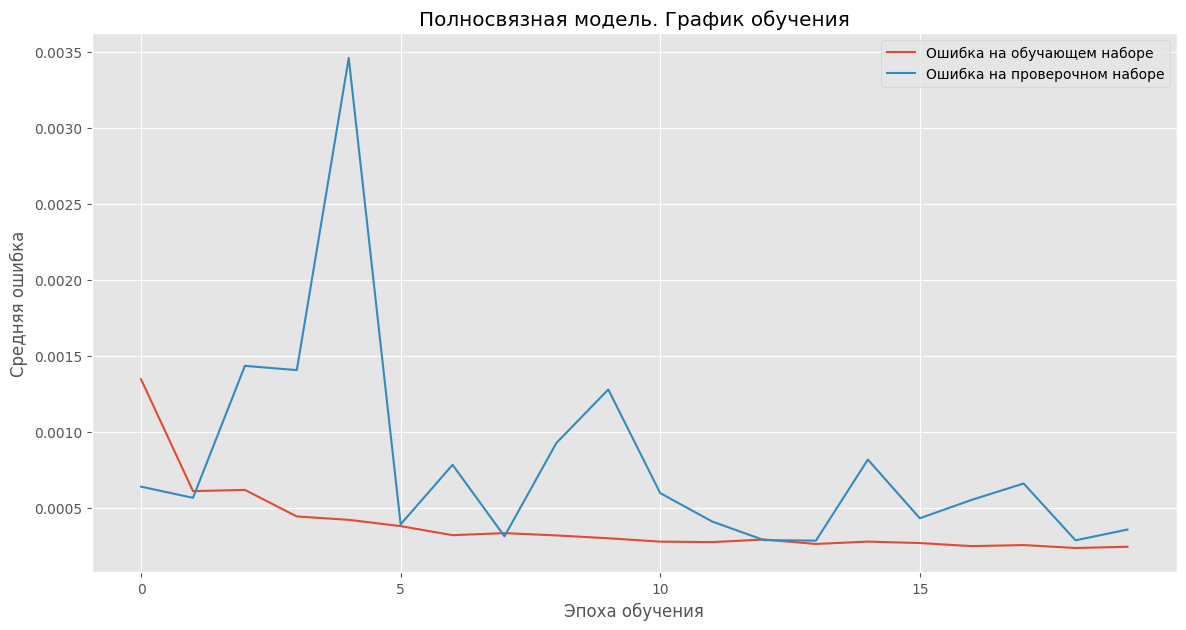

In [ ]:
history_plot(model_dense.history, 'Полносвязная модель')

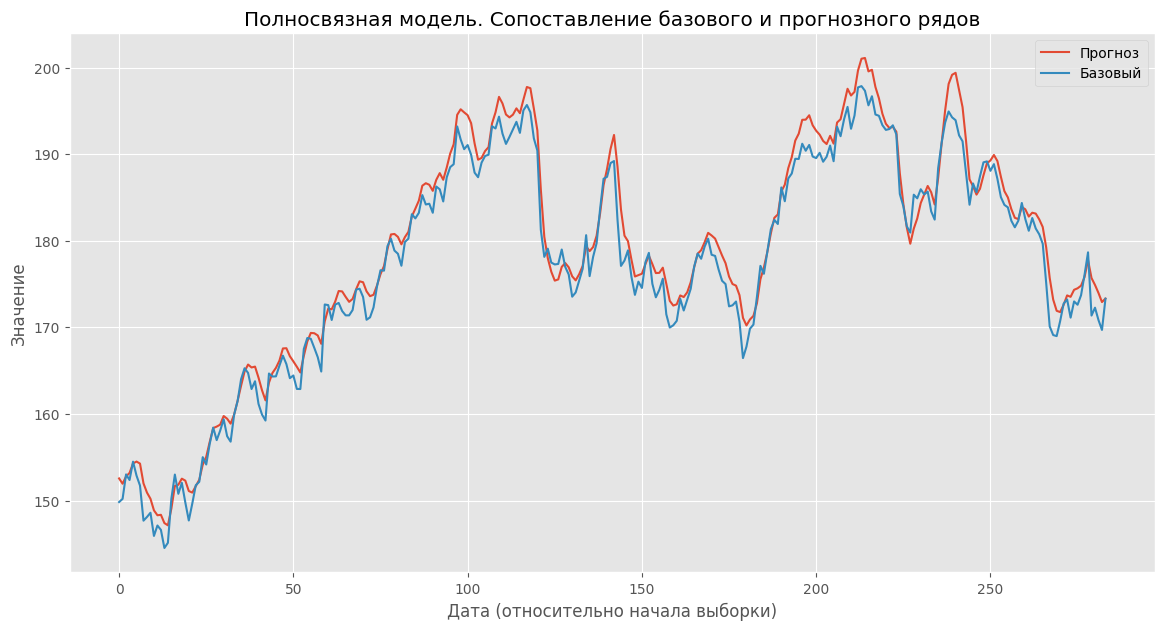

In [ ]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model_dense, x_test, y_test, scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
show_predict(y_pred, y_true, title=f'Полносвязная модель. Сопоставление базового и прогнозного рядов')



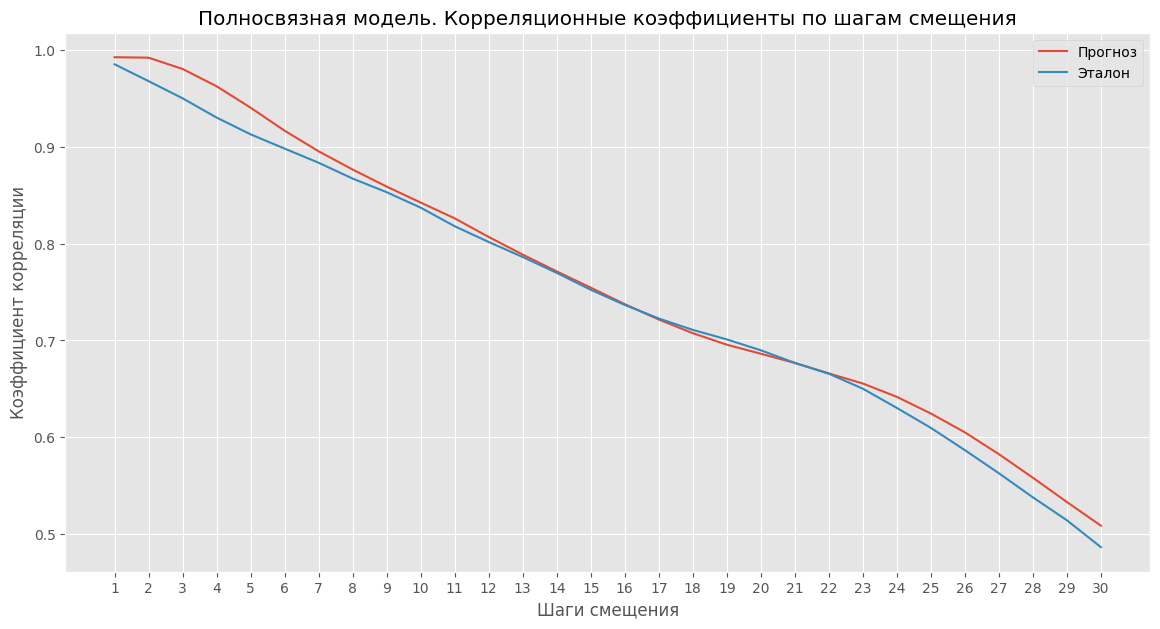

In [ ]:
# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, title=f'Полносвязная модель. Корреляционные коэффициенты по шагам смещения')

### 2. Рекуррентная модель LSTM(50)

#### Архитектура

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=generator[0][0].shape[1:]))
lstm_model.add(Dense(10, activation='relu'))
lstm_model.add(Dense(n_features))

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_12 (Dense)            (None, 10)                510       
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 10921 (42.66 KB)
Trainable params: 10921 (42.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Обучение

In [ ]:
lstm_model.fit(generator, validation_data=validator, epochs=20)

Epoch 1/20
2258/2258 [==============================] - 18s 7ms/step - loss: 0.0103 - val_loss: 0.0015
Epoch 2/20
2258/2258 [==============================] - 20s 9ms/step - loss: 5.6063e-04 - val_loss: 7.8480e-04
Epoch 3/20
2258/2258 [==============================] - 17s 8ms/step - loss: 5.1393e-04 - val_loss: 0.0023
Epoch 4/20
2258/2258 [==============================] - 16s 7ms/step - loss: 3.5540e-04 - val_loss: 4.3083e-04
Epoch 5/20
2258/2258 [==============================] - 14s 6ms/step - loss: 3.0988e-04 - val_loss: 2.7163e-04
Epoch 6/20
2258/2258 [==============================] - 18s 8ms/step - loss: 2.9492e-04 - val_loss: 2.6300e-04
Epoch 7/20
2258/2258 [==============================] - 17s 7ms/step - loss: 2.7454e-04 - val_loss: 2.3484e-04
Epoch 8/20
2258/2258 [==============================] - 16s 7ms/step - loss: 2.3751e-04 - val_loss: 4.3524e-04
Epoch 9/20
2258/2258 [==============================] - 22s 10ms/step - loss: 2.1817e-04 - val_loss: 2.6548e-04
Epoch 10/20


#### Графики

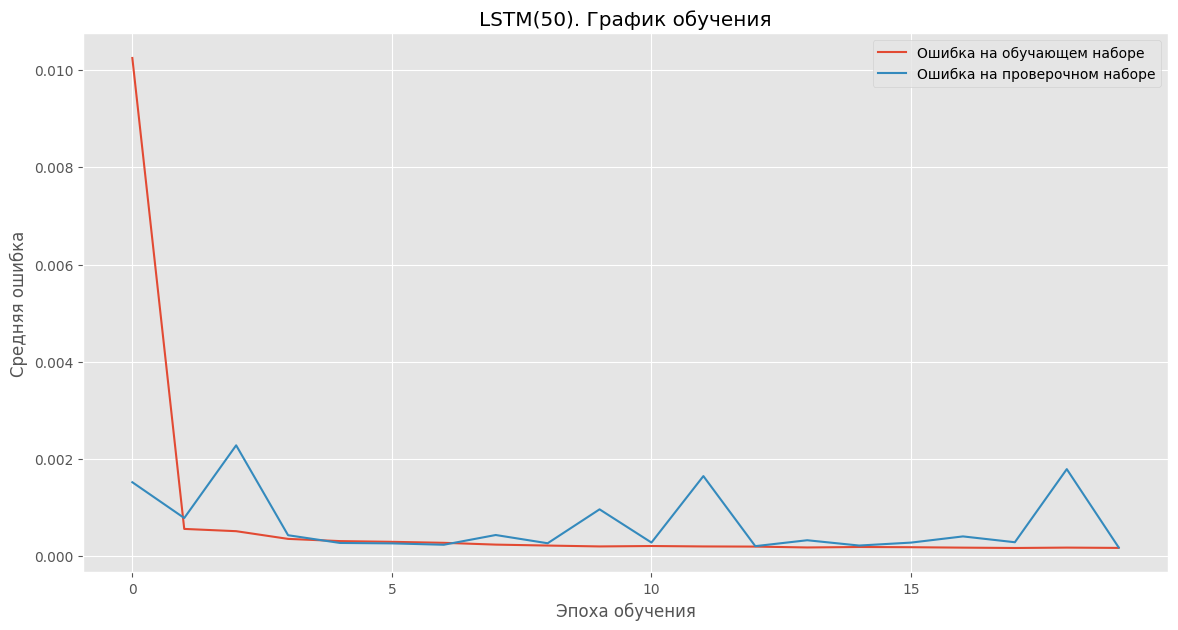

In [ ]:
history_plot(lstm_model.history, 'LSTM(50)')

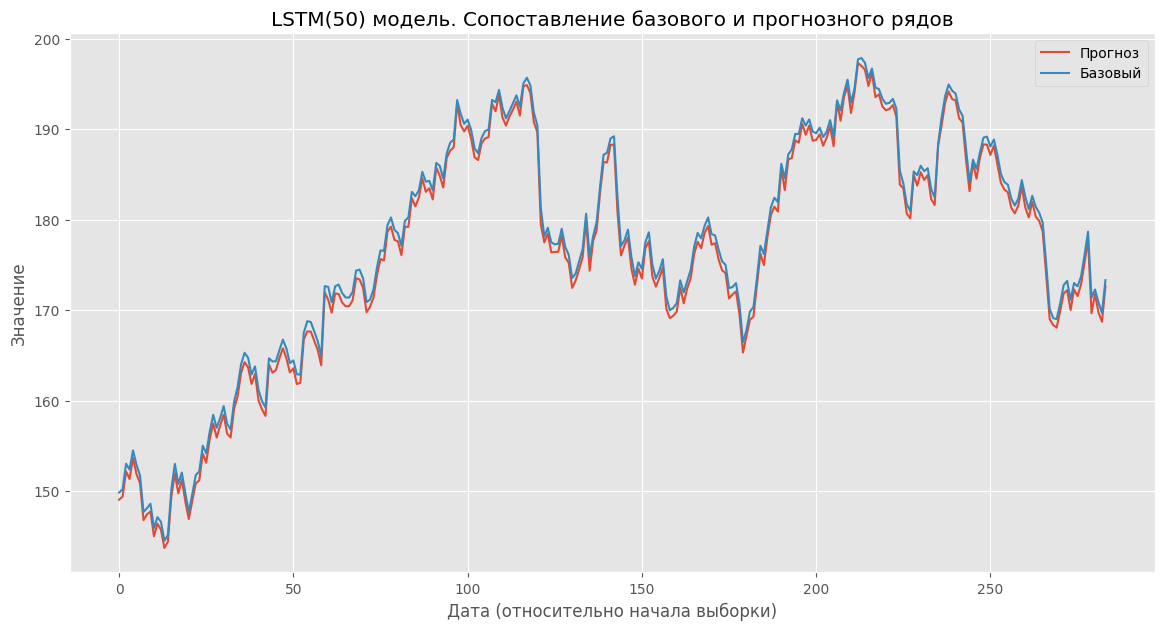

In [ ]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(lstm_model, x_test, y_test, scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
show_predict(y_pred, y_true, title=f'LSTM(50) модель. Сопоставление базового и прогнозного рядов')

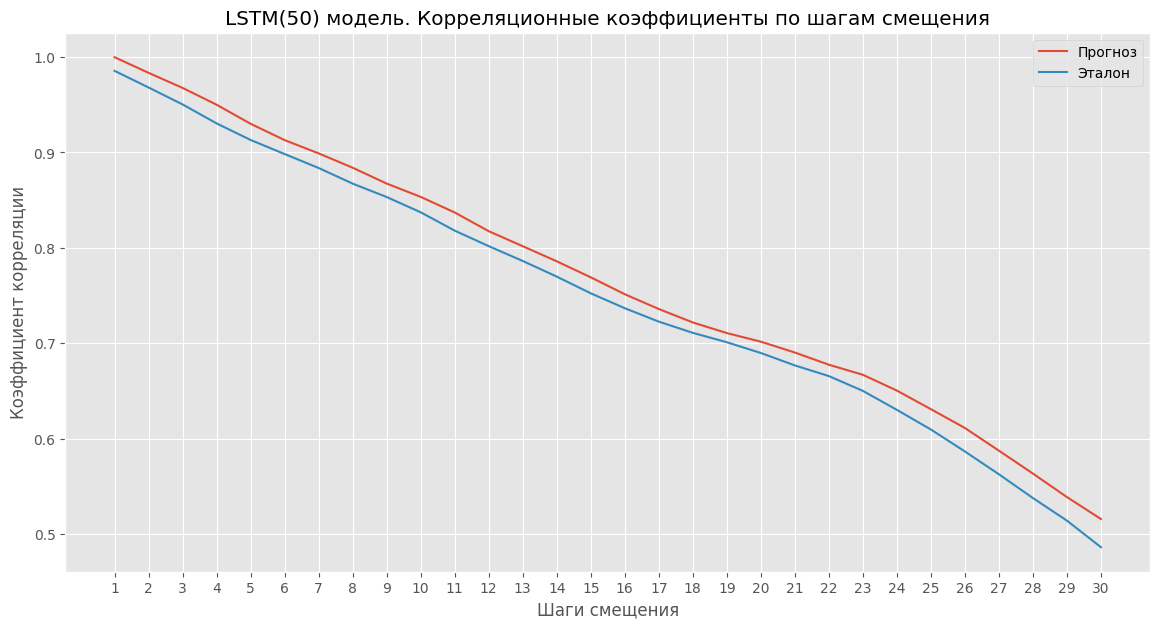

In [ ]:
# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, title=f'LSTM(50) модель. Корреляционные коэффициенты по шагам смещения')

### 3. Одномерная свертка Conv1D(64) х 2 + Dense(50)

#### Архитектура

In [ ]:
# Модель с одномерной сверткой
model_conv = Sequential()
model_conv.add(Conv1D(64, 4, input_shape=generator[0][0].shape[1:], activation='relu'))
model_conv.add(Conv1D(64, 4, activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(50, activation='relu'))
model_conv.add(Dense(n_features, activation='linear'))

model_conv.compile(optimizer='adam', loss='mse')
model_conv.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 11, 64)            320       
                                                                 
 conv1d_5 (Conv1D)           (None, 8, 64)             16448     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 50)                12850     
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                      

#### Обучение

In [ ]:
model_conv.fit(generator, validation_data=validator, epochs=20)

Epoch 1/20
2258/2258 [==============================] - 8s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 2/20
2258/2258 [==============================] - 6s 3ms/step - loss: 0.0011 - val_loss: 0.0056
Epoch 3/20
2258/2258 [==============================] - 15s 7ms/step - loss: 8.8002e-04 - val_loss: 8.9344e-04
Epoch 4/20
2258/2258 [==============================] - 8s 4ms/step - loss: 7.2940e-04 - val_loss: 0.0017
Epoch 5/20
2258/2258 [==============================] - 8s 3ms/step - loss: 7.5969e-04 - val_loss: 0.0018
Epoch 6/20
2258/2258 [==============================] - 6s 3ms/step - loss: 6.3671e-04 - val_loss: 8.9515e-04
Epoch 7/20
2258/2258 [==============================] - 8s 3ms/step - loss: 5.7422e-04 - val_loss: 0.0023
Epoch 8/20
2258/2258 [==============================] - 7s 3ms/step - loss: 5.7568e-04 - val_loss: 5.8571e-04
Epoch 9/20
2258/2258 [==============================] - 6s 3ms/step - loss: 4.8203e-04 - val_loss: 0.0015
Epoch 10/20
2258/2258 [==================

#### Графики

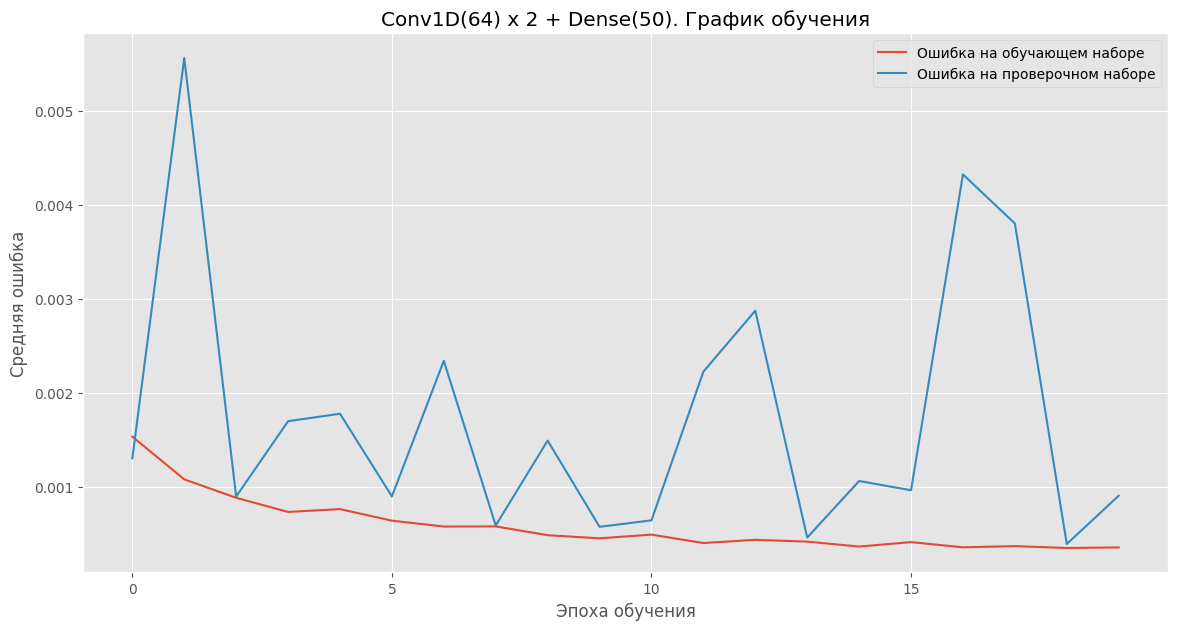

In [ ]:
history_plot(model_conv.history, 'Conv1D(64) х 2 + Dense(50)')

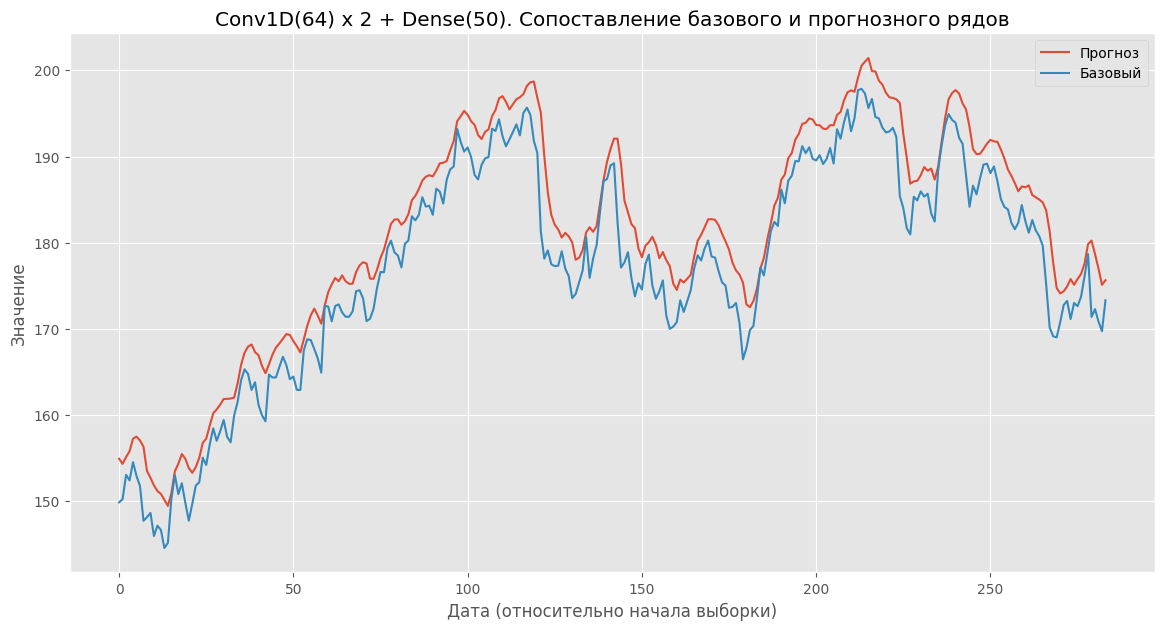

In [ ]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model_conv, x_test, y_test, scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
show_predict(y_pred, y_true, title=f'Conv1D(64) х 2 + Dense(50). Сопоставление базового и прогнозного рядов')

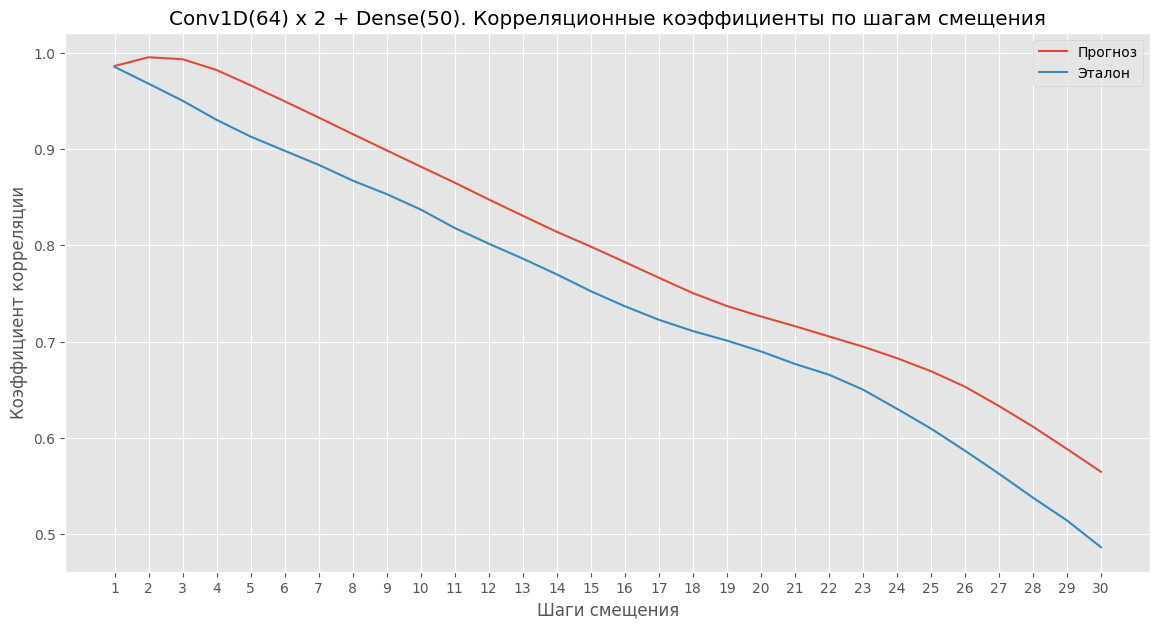

In [ ]:
# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, title=f'Conv1D(64) х 2 + Dense(50). Корреляционные коэффициенты по шагам смещения')

### Выводы

Мы рассмотрели 3 архитектуры нейронных сетей для анализа временных рядов и можно сделать следующие выводы:

* Мы видим, что все архитектуры имеют склонность к автокорреляции. Поэтому следует ожидать лучшие результаты при использовании обработки тренда.
* Задача предсказания точной цены закрытия акций не всегда верна. Наиболее часто нейронную сеть используют для предсказания направления цены: будет ли цена расти или падать в следующем периоде.
* В идеальном варианте график автокорреляции должен быть постоянно убывающим без холмика и стартовать максимально близко к 1. Такой идеальный случай нам показала модель LSTM. В двух других примерах прогнозный график корреляции стартует чуть ниже единицы, немного растет (или не убывает), и отодвигается от эталонной автокорреляции. Чем это плохо? При таком поведении графика прогнозной автокорреляции, часто можно заметить, что вместо предсказания действительного значения НС берет последнее значение из элемента выборки.

* Лучшей моделью оказалась LSTM модель.
* Худший результат показала одномерная свертка.

* По графику автокорреляции можно предсказывать насколько эффективна наша модель. Если появляется холмик на графике корреляции в районе первых двух шагов, то мы имеем эффект автокорреляции. В идеале холмика быть не должно, а график предсказания должен быть как можно ближе к эталонному.

> **ВАЖНО**. Даже если сеть достаточно точно предсказывает значение, оно не всегда может быть корректным. Нужно смотреть на график автокорреляции. Если график предсказания и реального значения имеют зависимость (наличие холмика, рост прогнозной автокорреляции на начальных шагах или большая удаленность между эталонной и прогнозной автокорреляции), то нейронка не предсказывает, а всего лишь повторяет то, что было несколько шагов назад.


А впереди вас ждет [домашняя работа](https://colab.research.google.com/drive/181g4qP5fB9PsqGCkcKAR37btxpRMU1Zt).